In [5]:
import numpy as np
from local_pso import pso2 as pso
import pandas as pd

# Parâmetros do problema
dias_no_mes = 30
medicos = ["Lara", "Cachoni", "Alex", "Rubben"]
num_medicos = len(medicos)

# Definições de turnos
DIURNO = 0
NOTURNO = 1

# Restrições dos médicos (exemplo)
restricoes = {
    "Lara": {"dias": ["segunda", "terça", "quarta"], "periodo": None, "max_plantao": 10, "min_plantao": 5},
    "Cachoni": {"dias": None, "periodo": NOTURNO, "max_plantao": 20, "min_plantao": 15},
    "Alex": {"dias": None, "periodo": DIURNO, "max_plantao": 10, "min_plantao": 4},
    "Rubben": {"dias": ["quinta", "sexta"], "periodo": DIURNO, "max_plantao": 12, "min_plantao": 8}
}

# Conversão de dias da semana para índices
dias_semana = ["segunda", "terça", "quarta", "quinta", "sexta", "sábado", "domingo"]
dia_semana_idx = {dia: i for i, dia in enumerate(dias_semana)}

# Função de avaliação
def avaliar_escala(escala):
    penalidade = 0
    pontuacao = 0

    # Contar plantões por médico
    contagem_plantao = np.sum(escala, axis=(0, 1))

    # Verificar restrições
    for i, medico in enumerate(medicos):
        restricao = restricoes[medico]
        max_plantao = restricao["max_plantao"]
        min_plantao = restricao["min_plantao"]
        dias_restritos = restricao.get("dias")
        periodo_restrito = restricao.get("periodo")

        # Penalizar se exceder ou não atingir o número de plantões
        if contagem_plantao[i] > max_plantao:
            penalidade += (contagem_plantao[i] - max_plantao) * 10
        if contagem_plantao[i] < min_plantao:
            penalidade += (min_plantao - contagem_plantao[i]) * 10

        for dia in range(dias_no_mes):
            dia_semana = dias_semana[dia % 7]
            if dias_restritos and dia_semana not in dias_restritos:
                # Penalizar plantões em dias restritos
                penalidade += np.sum(escala[dia, :, i]) * 10

            if periodo_restrito is not None:
                if escala[dia, 1 - periodo_restrito, i] == 1:
                    # Penalizar plantões em períodos restritos
                    penalidade += 10

    # Penalizar mais de um médico por turno
    for dia in range(dias_no_mes):
        for turno in range(2):
            if np.sum(escala[dia, turno, :]) != 1:
                penalidade += 100

    return penalidade - pontuacao

# Função de otimização usando PSO
def pso_optimization():
    lb = [0] * (dias_no_mes * 2)
    ub = [num_medicos - 1] * (dias_no_mes * 2)
    
    def funcao_objetivo(x):
        escala = np.zeros((dias_no_mes, 2, num_medicos), dtype=int)
        indices = np.round(x).astype(int)
        for dia in range(dias_no_mes):
            for turno in range(2):
                idx = indices[dia * 2 + turno]
                escala[dia, turno, idx] = 1
        return avaliar_escala(escala)
    
    xopt, hist = pso(funcao_objetivo, lb, ub, swarmsize=500, maxiter=100)
    melhor_escala = np.zeros((dias_no_mes, 2, num_medicos), dtype=int)
    indices = np.round(xopt).astype(int)
    for dia in range(dias_no_mes):
        for turno in range(2):
            idx = indices[dia * 2 + turno]
            melhor_escala[dia, turno, idx] = 1

    return melhor_escala, hist

# Executar a otimização
melhor_escala, h = pso_optimization()

# Exibir a escala resultante
dias = [f"Dia {i + 1}" for i in range(dias_no_mes)]
plantao_labels = ["Diurno", "Noturno"]

resultados = []

for dia in range(dias_no_mes):
        linha = [dias[dia]]
        for turno in range(2):
            for medico in range(num_medicos):
                if melhor_escala[dia, DIURNO, medico]:
                    d = medicos[medico]
                if melhor_escala[dia, NOTURNO, medico]:
                    n = medicos[medico]
                
        linha.append(d)
        linha.append(n)
        resultados.append(linha)

colunas = ["Dia", "Diurno", "Noturno"] 
df_resultado = pd.DataFrame(resultados, columns=colunas)
print(df_resultado)


Stopping search: maximum iterations reached --> 1000
       Dia   Diurno  Noturno
0    Dia 1  Cachoni   Rubben
1    Dia 2     Lara     Lara
2    Dia 3     Lara     Alex
3    Dia 4   Rubben   Rubben
4    Dia 5     Alex  Cachoni
5    Dia 6   Rubben  Cachoni
6    Dia 7  Cachoni  Cachoni
7    Dia 8     Alex  Cachoni
8    Dia 9     Alex  Cachoni
9   Dia 10     Alex     Lara
10  Dia 11   Rubben  Cachoni
11  Dia 12     Alex  Cachoni
12  Dia 13     Alex  Cachoni
13  Dia 14     Lara  Cachoni
14  Dia 15     Alex     Lara
15  Dia 16     Lara     Alex
16  Dia 17     Alex     Lara
17  Dia 18     Alex   Rubben
18  Dia 19     Lara  Cachoni
19  Dia 20     Alex  Cachoni
20  Dia 21     Lara  Cachoni
21  Dia 22     Lara  Cachoni
22  Dia 23  Cachoni  Cachoni
23  Dia 24     Alex  Cachoni
24  Dia 25   Rubben  Cachoni
25  Dia 26   Rubben   Rubben
26  Dia 27     Alex  Cachoni
27  Dia 28     Alex     Alex
28  Dia 29     Alex  Cachoni
29  Dia 30     Lara  Cachoni


In [3]:
len(h)

200

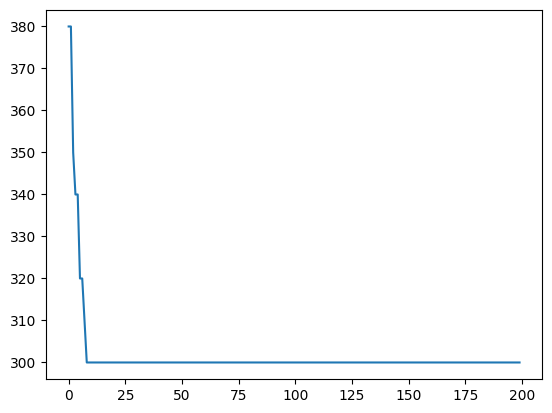

In [4]:
# Plot da evolução da função objetivo
import matplotlib.pyplot as plt

plt.plot(h)